# Categorizing Retail products using AI/ML techniques and GCP services

In [1]:
# %pip install nltk
# %pip install wordcloud

## Import necessary libraries and data

In [2]:
import pandas as pd 
import numpy as np 

import warnings
warnings.filterwarnings("ignore")

# %reload_ext autotime

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt  
sns.set(color_codes=True)        #adds color background (have to kill the kernel to see the changes of color)
%matplotlib inline 

# For Pre-processing and feature extraction
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# Libraries for text processing
import re             #regular expressions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS



from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [3]:
input1 = pd.read_csv('gs://ankit-team-46231447638/raw_data/retail_train.csv')
input1.head(10)

,train_id,name,item_condition_id,brand_name,shipping,item_description,target
0,0,MLB Cincinnati Reds T Shirt Size XL,3,NaN,1,No description yet,"Tops,T-shirts,Men"
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,0,This keyboard is in great condition and works ...,"Electronics,Components & Parts,Computers & Tab..."
2,2,AVA-VIV Blouse,1,Target,1,Adorable top with a hint of lace and a key hol...,"Women,Blouse,Tops & Blouses"
3,3,Leather Horse Statues,1,NaN,1,New with tags. Leather horses. Retail for [rm]...,"Home,Home Decor,Home Decor Accents"
4,4,24K GOLD plated rose,1,NaN,0,Complete with certificate of authenticity,"Women,Necklaces,Jewelry"
5,5,Bundled items requested for Ruie,3,NaN,0,"Banana republic bottoms, Candies skirt with ma...","Women,Other"
6,6,Acacia pacific tides santorini top,3,Acacia Swimwear,0,Size small but straps slightly shortened to fi...,"Women,Swimwear,Two-Piece"
7,7,Girls cheer and tumbling bundle of 7,3,Soffe,1,You get three pairs of Sophie cheer shorts siz...,"Girls,Sports & Outdoors,Apparel"
8,8,Girls Nike Pro shorts,3,Nike,0,Girls Size small Plus green. Three shorts total.,"Girls,Sports & Outdoors,Apparel"
9,9,Porcelain clown doll checker pants VTG,3,NaN,0,I realized his pants are on backwards after th...,"Vintage & Collectibles,Doll,Collectibles"


## EDA

In [4]:
print('Shape of retail_train data file is: {}'.format(input1.shape))

Shape of retail_train data file is: (29999, 7)


* We can see that there are 29,999 rows in the dataset. First we will perform operations on smaller dataset by randomizing and then reduce/increase the volume of data based on the kernel capacity.

In [5]:
input1 = shuffle(input1)
# input2 = input1.iloc[0:10000] ## reduce or increase as per system config
input2 = input1

#Reset index after shuffle
input2 = input2.reset_index()
input2 = input2.drop(['index'],axis=1)

In [6]:
input2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   train_id           29999 non-null  int64 
 1   name               29999 non-null  object
 2   item_condition_id  29999 non-null  int64 
 3   brand_name         17123 non-null  object
 4   shipping           29999 non-null  int64 
 5   item_description   29998 non-null  object
 6   target             29854 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.6+ MB


* We can observe that most of the features are of object datatype except for train_id, item_condition_id and shipping. Lets remove features which has less significance like 'train_id'.
* Values in 'item_condition_id' and 'shipping' columns can be replaced with string value to add signicance to model weights.
* Also 40% of the data is missing in brand_name, we can try to create synthetic data but that will add too much noise into the original dataset. Hence, we can either remove brand_name or replace NaN with string 'No brand name' (to prevent data loss).

In [7]:
# Replacing NaN in brand_name to 'No brand name'
input2["brand_name"].fillna("No brand name", inplace = True)
input2.head(10)

,train_id,name,item_condition_id,brand_name,shipping,item_description,target
0,12764,Girls size 11 pink/grey nikes,3,Nike,0,Great shape little girls pink and grey nikes. ...,"Kids,Shoes,Girls 2T-5T"
1,16532,Louis Vuitton Sarah,3,Louis Vuitton,0,"Authentic Sarah wallet, in very good condition...","Women,Wallets,Women's Accessories"
2,12293,freeshp charcoal cleansing mask,1,No brand name,1,Fast free ship charcoal facial cleansing foam/...,"Beauty,Face,Skin Care"
3,1507,Embellished Shorts (2),2,Abercrombie & Fitch,1,"Worn, but perfect condition :) Tags : Holliste...","Women,Shorts,Athletic Apparel"
4,28617,New! Too faced Deluxe Lip injections,1,Too Faced,0,Too faced Deluxe Lip injections! The lip injec...,"Beauty,Lips,Makeup"
5,20424,New Lularoe OS Leggings,1,LuLaRoe,1,Brand New OS Tribal/Geometric Lularoe Leggings,"Women,Athletic Apparel,Pants, Tights, Leggings"
6,12377,Victoria Secret Paris,1,Victoria's Secret,0,Victoria Secret Paris body mist. Please consid...,"Beauty,Women,Fragrance"
7,19309,Beautiful women's plaid dress,1,No brand name,0,Size medium. U.K. Size 12. Item purchased from...,"Women,Knee-Length,Dresses"
8,6099,Boys Nike tennis shoes,4,Nike,0,"Black, Velcro closure. Some wear to these but ...","Kids,Shoes,Boys 2T-5T"
9,26552,Rae Dunn Good Dog Canister,1,Rae Dunn,0,Rae Dunn Good Dog Canister New!! This is the e...,"Home,Home Decor,Home Decor Accents"


In [8]:
input2['item_condition_id'].value_counts()

1    13040
3     8727
2     7511
4      665
5       56
Name: item_condition_id, dtype: int64

In [9]:
input2['shipping'].value_counts()

0    16568
1    13431
Name: shipping, dtype: int64

Encoding integer values to string values which can add significance to our NN model.

In [10]:
encoding_dict = {
                  "item_condition_id": {1: 'worst', 2: 'bad', 3: 'good', 4: 'better', 5: 'best'},
                  "shipping": {0: 'paid by buyer', 1: 'paid by seller'}
                 }
input2 = input2.replace(encoding_dict)
input2.head(10)

,train_id,name,item_condition_id,brand_name,shipping,item_description,target
0,12764,Girls size 11 pink/grey nikes,good,Nike,paid by buyer,Great shape little girls pink and grey nikes. ...,"Kids,Shoes,Girls 2T-5T"
1,16532,Louis Vuitton Sarah,good,Louis Vuitton,paid by buyer,"Authentic Sarah wallet, in very good condition...","Women,Wallets,Women's Accessories"
2,12293,freeshp charcoal cleansing mask,worst,No brand name,paid by seller,Fast free ship charcoal facial cleansing foam/...,"Beauty,Face,Skin Care"
3,1507,Embellished Shorts (2),bad,Abercrombie & Fitch,paid by seller,"Worn, but perfect condition :) Tags : Holliste...","Women,Shorts,Athletic Apparel"
4,28617,New! Too faced Deluxe Lip injections,worst,Too Faced,paid by buyer,Too faced Deluxe Lip injections! The lip injec...,"Beauty,Lips,Makeup"
5,20424,New Lularoe OS Leggings,worst,LuLaRoe,paid by seller,Brand New OS Tribal/Geometric Lularoe Leggings,"Women,Athletic Apparel,Pants, Tights, Leggings"
6,12377,Victoria Secret Paris,worst,Victoria's Secret,paid by buyer,Victoria Secret Paris body mist. Please consid...,"Beauty,Women,Fragrance"
7,19309,Beautiful women's plaid dress,worst,No brand name,paid by buyer,Size medium. U.K. Size 12. Item purchased from...,"Women,Knee-Length,Dresses"
8,6099,Boys Nike tennis shoes,better,Nike,paid by buyer,"Black, Velcro closure. Some wear to these but ...","Kids,Shoes,Boys 2T-5T"
9,26552,Rae Dunn Good Dog Canister,worst,Rae Dunn,paid by buyer,Rae Dunn Good Dog Canister New!! This is the e...,"Home,Home Decor,Home Decor Accents"


In [11]:
input2['target'].value_counts()

Women,Athletic Apparel,Pants, Tights, Leggings    1211
Women,T-Shirts,Tops & Blouses                      910
Beauty,Face,Makeup                                 727
Beauty,Lips,Makeup                                 669
Beauty,Eyes,Makeup                                 549
                                                  ... 
Toys,Other,Handmade                                  1
Vintage & Collectibles,Other,Jewelry                 1
Signs,Woodworking,Handmade                           1
Women,Maternity,Sweaters                             1
Geekery,Science,Handmade                             1
Name: target, Length: 807, dtype: int64

* Top 5 target categories include words like 'Women', 'Beauty', etc., similarly, bottom 5 target categories include words related to 'Home', 'Vintage', etc.,

### Univariate Analysis

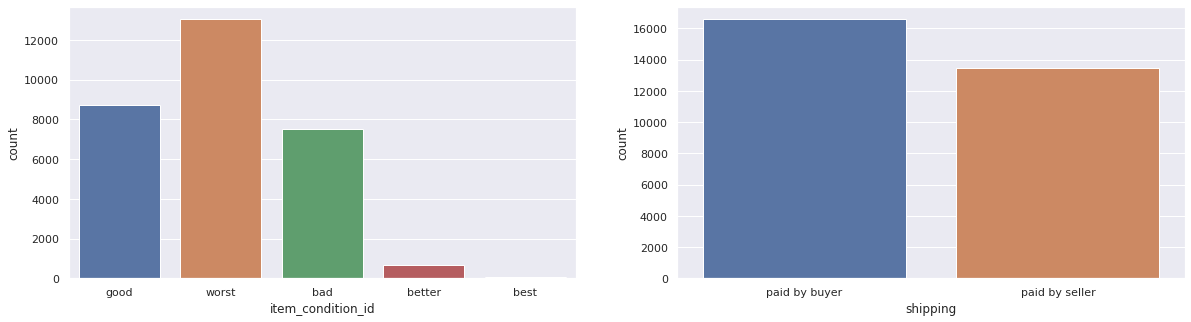

In [12]:
# Basic plots for item_condition and shipping

plt.figure(figsize= (20,5));

plt.subplot(1,2,1);
sns.countplot(input2['item_condition_id']);

plt.subplot(1,2,2);
sns.countplot(input2['shipping']);


* Most of the categories belong to item_conditions_id 1, 2 and 3.
* With regards to shipping, the product shipping fee is mostly paid by buyer which slightly higher than that paid by seller.

### Bi-variate Analysis

In [13]:
# # Bi-variate analysis for item_condition and shipping

# plt.figure(figsize=(10,5))

# plt.subplot(1,1,1)
# sns.barplot(input2['item_condition_id'], input2['shipping']);

Creating a new string using all columns and combining with item_description column

In [14]:
input2["New_desc"] = "I bought " + input2["name"] + " which is in " + input2["item_condition_id"] + " condition of " + input2["brand_name"] + " brand for which shipping fee was " + input2["shipping"] + "."
input2["New_desc"][1]

'I bought Louis Vuitton Sarah which is in good condition of Louis Vuitton brand for which shipping fee was paid by buyer.'

In [15]:
input2["New_desc"] = input2["New_desc"] + " " + input2["item_description"]
input2["New_desc"][1]

'I bought Louis Vuitton Sarah which is in good condition of Louis Vuitton brand for which shipping fee was paid by buyer. Authentic Sarah wallet, in very good condition. I would rate it a 9/10. The only thing is a little dirt inside the coin pouch from having coins stored in there. There are no rips, tears, or other flaws. Price is firm!'

In [16]:
# Dropping columns since we have taken those column values to new column 'New_desc'.
input3 = input2.drop(['train_id', 'name', 'item_condition_id', 'brand_name', 'shipping', 'item_description'], axis=1)

In [17]:
# Check null values
input3.isnull().sum()

target      145
New_desc      1
dtype: int64

In [18]:
# Drop rows with null values 
input4 = input3.dropna()
input4.reset_index(inplace=True)
input4.drop('index',inplace=True,axis=1)
input4.tail()

,target,New_desc
29848,"Kids,Toys,Action Figures & Statues",I bought Funko Pop Chase Punisher Limited Edit...
29849,"Women,Knee-Length,Dresses",I bought Lularoe Julia XS which is in worst co...
29850,"Women,Tank, Cami,Tops & Blouses",I bought F21 crop top which is in bad conditio...
29851,"Women,Athletic Apparel,Pants, Tights, Leggings",I bought Black size small jumpsuit cotton USAm...
29852,"Bracelets,Women,Jewelry",I bought Tory burch bangle which is in worst c...


In [19]:
print('Shape of retail_train data file after replacing null values and coverting integer to string: {}'.format(input4.shape))

Shape of retail_train data file after replacing null values and coverting integer to string: (29853, 2)


In [20]:
# ax = input4['target'].value_counts().plot(kind='bar',
#                                     figsize=(15,8),
#                                     title="target")
# ax.set_xlabel("Frequency of category")
# ax.set_ylabel("Target")
# plt.show()

#### Wordcloud before pre-processing

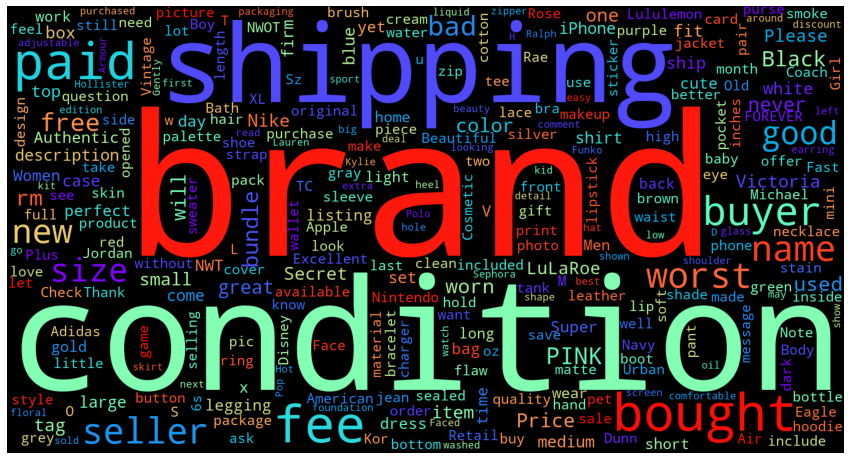

In [22]:
# Print word cloud

wordcloud = WordCloud(width = 1500, height = 800, random_state=0, background_color='black', colormap='rainbow', \
min_font_size=5, max_words=300, collocations=False).generate(" ".join(input4['New_desc'].values))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Data pre-processing

Data pre-processing steps taken before applying model on the data

* Converting to lower case
* Removing multiple spaces between words
* Removing special characters
* Removing punctuations
* Removing stopwords
* Lemmatization to get the root word

In [19]:
#nltk.download('stopwords')
stop = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()

In [23]:
input4['New_desc'][44]

'I bought Artist Couture Highlighter Illuminati which is in good condition of No brand name brand for which shipping fee was paid by buyer. Diamond glow powder. Opened, swatched but never used. No box.'

In [27]:
#nltk.download('all')

In [28]:
#Converting headlines to lower case
input4['clean_new_desc'] = input4['New_desc'].apply(lambda x : x.lower())

#Removing multiple spaces between words
input4['clean_new_desc'] = input4['clean_new_desc'].apply(lambda x: re.sub(' +', ' ', x))

#Removing punctiation marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing special characters
def remove_specialchars(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords and lemmatization
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)

#Total function
def cleaning(text):
    text = remove_punctuations(text)
    text = remove_specialchars(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

input4['clean_new_desc'] = input4['clean_new_desc'].apply(cleaning)

In [29]:
input4.to_csv('gs://ankit-team-46231447638/raw_data/clean_data.csv', index=False)